In [1]:
!pip install -U fashion-clip

  Using cached annoy-1.17.3.tar.gz (647 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 24.6/24.6 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 7.6/7.6 MB 3.7 MB/s eta 0:00:00
  Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)
  Using cached validators-0.22.0-py3-none-any.whl (26 kB)
     -------------------------------------- 135.8/135.8 kB 4.1 MB/s eta 0:00:00
  Using cached torch-2.1.0-cp310-cp310-win_amd64.whl (192.3 MB)
     -------------------------------------- 493.7/493.7 kB 3.9 MB/s eta 0:00:00
  Using cached ipyplot-1.1.1-py3-none-any.whl (13 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached s3transfer-0.7.0-py3-none-any.whl (79 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
     ---------------------------------------- 11.3/11.3 MB 5.4 MB/s eta 0:00:00
     -------------------------------------- 325.


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [2]:
fclip = FashionCLIP('fashion-clip')

In [3]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# drop items that have the same description
subset = articles.drop_duplicates("detail_desc").copy()

# remove items of unkown category
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# FashionCLIP has a limit of 77 tokens, let's play it safe and drop things with more than 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# We also drop products types that do not occur very frequently in this subset of data
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

# lots of data here, but we will just use only descriptions and a couple of other columns
subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [4]:
subset.to_csv("subset_data.csv", index=False)
f"There are {len(subset)} elements in the dataset"

'There are 3104 elements in the dataset'

In [5]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# we create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

100%|██████████| 97/97 [04:58<00:00,  3.07s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [02:07<00:00,  1.31s/it]


In [6]:
precision = 0

# we could batch this operation to make it faster
for index, t in enumerate(text_embeddings):
    arr = t.dot(image_embeddings.T)

    best = arr.argsort()[-5:][::-1]

    if index in best:
        precision +=1

round(precision/len(text_embeddings), 2)

0.54

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 14.29it/s]


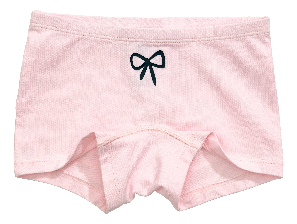

In [7]:
text_embedding = fclip.encode_text(["a pair of pink shorts"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

In [ ]:
text_embedding = fclip.encode_text(["a house"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

In [8]:
labels = subset["product_type_name"].unique()
print(f"These are our labels: {labels}")

These are our labels: ['Vest top' 'Hair/alice band' 'Leggings/Tights' 'T-shirt' 'Sneakers'
 'Sunglasses' 'Cardigan' 'Gloves' 'Underwear Tights' 'Hoodie' 'Other shoe'
 'Shorts' 'Jumpsuit/Playsuit' 'Dress' 'Trousers' 'Belt' 'Socks'
 'Underwear bottom' 'Bodysuit' 'Hat/beanie' 'Scarf' 'Jacket'
 'Other accessories' 'Bra' 'Swimwear bottom' 'Blazer' 'Top' 'Polo shirt'
 'Sweater' 'Necklace' 'Pyjama set' 'Blouse' 'Bag' 'Shirt' 'Coat' 'Boots'
 'Skirt' 'Garment Set' 'Bikini top' 'Sandals' 'Dungarees' 'Earring'
 'Cap/peaked' 'Ballerinas' 'Swimsuit' 'Hat/brim']


In [9]:
labels_prompt = [f"a photo of a {k}" for k in labels]

label_embeddings = fclip.encode_text(labels_prompt, batch_size=32)
label_embeddings = label_embeddings/np.linalg.norm(label_embeddings, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

2it [00:01,  1.05it/s]                       


In [10]:
# let's compute the class distribution for all images
predicted_classes_distribution = label_embeddings.dot(image_embeddings.T)

In [11]:
# let's take the best label (the most similar to the image)
predicted = [labels[k] for k in np.argmax(predicted_classes_distribution, axis=0)]

In [12]:
print(classification_report(subset["product_type_name"], predicted))

                   precision    recall  f1-score   support

              Bag       0.97      0.85      0.91        40
       Ballerinas       0.67      0.15      0.25        13
             Belt       0.75      0.92      0.83        13
       Bikini top       0.68      0.73      0.70        37
           Blazer       0.94      0.87      0.90        38
           Blouse       0.47      0.79      0.59       135
         Bodysuit       0.53      0.64      0.58        25
            Boots       0.91      0.65      0.75        31
              Bra       0.90      0.77      0.83        60
       Cap/peaked       0.95      0.86      0.90        21
         Cardigan       0.58      0.86      0.69        49
             Coat       0.18      0.92      0.30        12
            Dress       0.92      0.76      0.83       293
        Dungarees       0.32      0.67      0.43        12
          Earring       0.98      0.84      0.90        55
      Garment Set       0.71      0.18      0.29       

In [13]:
classes = subset["product_group_name"].tolist()
X_train, X_test, y_train, y_test = train_test_split(image_embeddings, classes, test_size=0.20, random_state=32, stratify=classes)

In [14]:
clf = LogisticRegression(random_state=0, class_weight="balanced").fit(X_train, y_train)

In [15]:
print(classification_report(y_test, clf.predict(X_test)))

                    precision    recall  f1-score   support

       Accessories       0.86      1.00      0.92        65
 Garment Full body       0.69      0.95      0.80        73
Garment Lower body       0.98      0.94      0.96       131
Garment Upper body       1.00      0.85      0.92       258
         Nightwear       0.58      1.00      0.74         7
             Shoes       1.00      0.90      0.95        30
    Socks & Tights       0.75      0.90      0.82        10
          Swimwear       0.65      0.68      0.67        19
         Underwear       0.96      0.96      0.96        28

          accuracy                           0.90       621
         macro avg       0.83      0.91      0.86       621
      weighted avg       0.92      0.90      0.91       621
